Tuning opportunities
1. Configuration-Based Hyperparameter Tuning
2. Enhanced Data Augmentation
3. Improved Model Architecture
4. Advanced Callbacks
5. Transfer Learning (Often Best Results)
6. Class Imbalance Handling
7. Ensemble Methods
8. Systematic Tuning Strategy

Quick Start Guide:
For best results immediately: Set "backbone": "mobilenet" and "fine_tune": True
For faster training: Set "backbone": "custom_cnn" and "aug_level": "light"
For maximum accuracy: Enable ensemble with "use_ensemble": True
For experimentation: Uncomment Cell 17 to run systematic tuning

In [ ]:
# =======================================================================
# Facial Emotion Recognition - Enhanced with 8 Tuning Improvements
# =======================================================================

import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image, UnidentifiedImageError
from pathlib import Path
from datetime import datetime

# TensorFlow and Keras
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"Python executable: {sys.executable}")

import seaborn as sns

# Deep learning libraries
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Flatten, Dropout, Dense, Input, 
    GlobalAveragePooling2D, Conv2D, 
    BatchNormalization, Activation, MaxPooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, 
    ReduceLROnPlateau, LearningRateScheduler)
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight


print("=" * 70)
print("= is device GPU device")
print("=" * 70)

from tensorflow.keras import mixed_precision
import tensorflow as tf

# Enable mixed precision only if a GPU is available
if tf.config.list_physical_devices('GPU'):
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled: mixed_float16")
else:
    mixed_precision.set_global_policy('float32')
    print("No GPU detected — using float32")
    
print("Global policy:", mixed_precision.global_policy())


print("=" * 70)
print("✅ All libraries imported successfully")

In [ ]:
# =======================================================================
# Environment Detection
# =======================================================================

def is_on_kaggle():
    """Detect if running on Kaggle."""
    return os.path.exists('/kaggle/input')

def get_data_path():
    """Detect environment and return appropriate data path."""
    if is_on_kaggle():
        print("🌐 Running on Kaggle")
        import kagglehub
        image_path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")
        folder_path = os.path.join(image_path, "images")
    else:
        print("💻 Running on local machine")
        folder_path = "data/images/"
    
    return folder_path

folder_path = get_data_path()
print(f"Data folder path: {folder_path}")

In [ ]:
# =======================================================================
# Enhanced Configuration with Tuning Options
# =======================================================================

cfg = {
    # Model Architecture
    "backbone": "mobilenet",  # Options: "custom_cnn", "mobilenet", "efficientnet"
    
    # Image Parameters
    "picture_size": 48,  # Try: 64, 96 for more detail
    "color_mode": "grayscale",  # "grayscale" or "rgb" (rgb required for transfer learning)
    
    # Training Parameters
    "batch_size": 64,  # Reduced from 128 for better gradient estimates
    "epochs": 5,  # Increased from 30
    "learning_rate": 0.0001,  # Adjusted learning rate
    "dropout_rate": 0.25,  # Increased from 0.25
     
    # Dense layers
    "dense_units": [512],  # Added an extra dense layer (Improvement #6)
    
    # Data Augmentation (Improvement #2)
    "aug_level": "light",  # Options: "none", "light", "strong", "aggressive"
    
    # Advanced Training
    "precision": "mixed",  # "float32" or "mixed"
    "fine_tune": True,  # Enable fine-tuning for transfer learning
    "fine_tune_epochs": 0,
    
    # Optimizer
    "optimizer": "adam",  # Options: "adam", "adamw", "sgd"
    "weight_decay": 1e-4,  # For AdamW
    
    # Learning Rate Schedule
    "use_lr_schedule": True,  # Cosine annealing (Improvement #5)
    
    # Class Weights (Improvement #3)
    "use_class_weights": True,
    
    # Ensemble (Improvement #7)
    "use_ensemble": False,  # Set True to train multiple models
    "n_ensemble_models": 3,
    
    # Model Parameters
    "no_of_classes": 7,
}

print("Configuration loaded:")
for key, value in cfg.items():
    print(f"  {key}: {value}")

# Extract commonly used values
picture_size = cfg["picture_size"]
batch_size = cfg["batch_size"]
epochs = cfg["epochs"]
learning_rate = cfg["learning_rate"]
no_of_classes = cfg["no_of_classes"]
dropout_rate = cfg["dropout_rate"]
dense_units = cfg["dense_units"]

In [ ]:
# near your cfg definition (apply before building generators)
cfg.update({
    "picture_size": 96,
    "color_mode": "rgb",
    "head_epochs": 1,
    "fine_tune": True,
    "fine_tune_epochs": 1,
    "fine_tune_unfreeze_layers": 30,
})
# rebind frequently used variables
picture_size = cfg["picture_size"]
color_mode = cfg["color_mode"]

print("Configuration loaded:")
for key, value in cfg.items():
    print(f"  {key}: {value}")

In [ ]:
# =======================================================================
# Enhanced Data Augmentation
# =======================================================================

aug_map = {
    "none": dict(rescale=1./255),
    
    "light": dict(
        rescale=1./255,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    ),
    
    "strong": dict(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.2,
        brightness_range=[0.7, 1.3],
        horizontal_flip=True,
        fill_mode='nearest'
    ),
    
    "aggressive": dict(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        brightness_range=[0.6, 1.4],
        horizontal_flip=True,
        channel_shift_range=0.2,
        fill_mode='nearest'
    )
}

# Create data generators
datagen_train = ImageDataGenerator(**aug_map[cfg["aug_level"]])
datagen_validation = ImageDataGenerator(**aug_map[cfg["aug_level"]])

print(f"✅ Using '{cfg['aug_level']}' augmentation level for training data")
print(f"✅ Using '{cfg['aug_level']}' augmentation level for validation data")

In [ ]:
# =======================================================================
# Load Training and Validation Data
# =======================================================================

# Determine color mode
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Prepare augmentation for train (remove rescale if present)
train_aug = aug_map[cfg["aug_level"]].copy()
train_aug.pop("rescale", None)
train_aug.update({"preprocessing_function": preprocess_input})
datagen_train = ImageDataGenerator(**train_aug)

# Validation: only preprocessing (no augmentation)
datagen_validation = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create flows (must use the same picture_size and color_mode)
train_set = datagen_train.flow_from_directory(
    os.path.join(folder_path, "train"),
    target_size=(picture_size, picture_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

validation_set = datagen_validation.flow_from_directory(
    os.path.join(folder_path, "validation"),
    target_size=(picture_size, picture_size),
    color_mode=color_mode,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
)

print("Train image shape:", train_set.image_shape)
print("Val image shape:  ", validation_set.image_shape)

print(f"\n✅ Data loaded successfully")
print (f"Colour Mode: {color_mode}")
print(f"Training samples: {train_set.n}")
print(f"Validation samples: {validation_set.n}")
print(f"Class indices: {train_set.class_indices}")

class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
# =======================================================================
# Calculate Class Weights for Imbalanced Data
# =======================================================================

class_weight_dict = None

if cfg.get("use_class_weights", False):
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_set.classes),
        y=train_set.classes
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    print("\n✅ Class weights calculated:")
    for emotion, weight in zip(class_labels, class_weights):
        print(f"  {emotion:>10}: {weight:.3f}")
else:
    print("\n⚠️  Class weights disabled")

In [ ]:
def build_transfer_learning_model(cfg):
    """Build and compile a MobileNetV2 transfer-learning model.
       Returns (model, base_model).
    """

    picture_size = cfg["picture_size"]
    color_mode = cfg["color_mode"]
    batch_size = cfg["batch_size"]

    channels = 1 if cfg["color_mode"] == "grayscale" else 3
    input_shape = (picture_size, picture_size, channels)

    # Input
    inp = Input(shape=input_shape)

    # If grayscale, convert to RGB for ImageNet backbone
    if channels == 1:
        x = tf.keras.layers.Lambda(lambda z: tf.image.grayscale_to_rgb(z))(inp)
    else:
        x = inp

    # Pre-trained backbone
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(picture_size, picture_size, 3), pooling=None)
    # Attach to our RGB input
    x = base_model(x, training=False)

    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dropout(cfg["dropout_rate"])(x)
    for units in cfg["dense_units"]:
        x = Dense(units, activation='relu')(x)
        x = Dropout(cfg["dropout_rate"])(x)
    out = Dense(no_of_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs=inp, outputs=out)

    # Freeze base model initially
    if not cfg.get("fine_tune", False):
        base_model.trainable = False
    else:
        # Start by freezing; we'll unfreeze later for fine-tuning if desired
        base_model.trainable = False

    # Optimizer selection (same logic as your custom CNN)
    optimizer_name = cfg.get("optimizer", "adam")
    if optimizer_name == "adam":
        opt = Adam(learning_rate=cfg["learning_rate"])
    elif optimizer_name == "adamw":
        opt = tf.keras.optimizers.AdamW(
            learning_rate=cfg["learning_rate"],
            weight_decay=cfg.get("weight_decay", 1e-4)
        )
    elif optimizer_name == "sgd":
        opt = tf.keras.optimizers.SGD(
            learning_rate=cfg["learning_rate"],
            momentum=0.9,
            nesterov=True
        )

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model, base_model

In [ ]:
# =======================================================================
# Enhanced Model Building Functions
# =======================================================================


def build_improved_cnn(cfg):
    """Enhanced CNN with better architecture."""
    
    
    #color_mode = cfg.get("color_mode", "grayscale")
    channels = 1 if color_mode == "grayscale" else 3
    input_shape = (picture_size, picture_size, channels)
    
    print(f"Building Improved CNN with input shape: {input_shape}")
    
    model = Sequential()
    
    # Block 1 - Double Conv
    model.add(Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        padding='same', 
                        input_shape=input_shape,
                        name='conv2d_1'))

    # Block 2 - Double Conv
    model.add(Conv2D(filters=128, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_2'))
    model.add(BatchNormalization(name='bn_2'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_2'))
    model.add(Dropout(dropout_rate,name='dropout_2'))
    
    # Block 3 - Double Conv
    model.add(Conv2D(filters=512, 
                      kernel_size=(5, 5), 
                      padding='same',
                      name='conv2d_3'))
    model.add(BatchNormalization(name='bn_3'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_3'))
    model.add(Dropout(dropout_rate,name='dropout_3'))
    
    # Block 4 - Double Conv
    model.add(Conv2D(filters=512, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_4'))
    model.add(BatchNormalization(name='bn_4'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_4'))
    model.add(Dropout(dropout_rate,name='dropout_4'))

    
    # Block 5 - Double Conv
    model.add(Conv2D(filters=512, 
                      kernel_size=(3, 3), 
                      padding='same',
                      name='conv2d_5'))
    model.add(BatchNormalization(name='bn_5'))
    model.add(Activation('elu'))
    model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_5'))
    model.add(Dropout(dropout_rate,name='dropout_5'))
     
    
    # Output layer
    # Add dense layers before output
    model.add(Flatten())
    for idx, units in enumerate(dense_units):
        print(f"Adding dense layer with {units} units")
        model.add(Dense(units, name=f"dense_{idx+1}"))
        model.add(BatchNormalization(name=f"bn_dense_{idx+1}"))
        model.add(Activation('relu', name=f"act_dense_{idx+1}"))
        model.add(Dropout(dropout_rate, name=f"dropout_dense_{idx+1}"))
    model.add(Dense(no_of_classes, activation='softmax', dtype='float32', name='output_layer'))

   
    # Compile with optimizer choice
    optimizer_name = cfg.get("optimizer", "adam")
    if optimizer_name == "adam":
        opt = Adam(learning_rate=learning_rate)
    elif optimizer_name == "adamw":
        opt = tf.keras.optimizers.AdamW(
            learning_rate=learning_rate,
            weight_decay=cfg.get("weight_decay", 1e-4)
        )
    elif optimizer_name == "sgd":
        opt = tf.keras.optimizers.SGD(
            learning_rate=learning_rate,
            momentum=0.9,
            nesterov=True
        )
    
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    
    return model, None

# Build model based on configuration
print(f"\n{'='*70}")
print(f"Building model with '{cfg['backbone']}' backbone...")
print(f"{'='*70}")

In [ ]:

# Replace the model building section with:
if cfg["backbone"] == "custom_cnn":
    model, base_model = build_improved_cnn(cfg)
elif cfg["backbone"] == "mobilenet":
    model, base_model = build_transfer_learning_model(cfg)
else:
    raise ValueError(f"Unsupported backbone: {cfg['backbone']}")

print(f"\n✅ Model built successfully")
model.summary()

In [ ]:
# =======================================================================
# Advanced Training Callbacks
# =======================================================================

# Checkpoint
checkpoint = ModelCheckpoint('best_model.keras',
                                    monitor='val_accuracy',
                                    save_best_only=True,
                                    mode='max',
                                    verbose=1
                                )

# Early stopping with more patience
early_stopping = EarlyStopping(monitor='val_loss',
                                    patience=5,  # Increased from 10
                                    restore_best_weights=True,
                                    verbose=1
                                )

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.5,
                    patience=2,  # Increased from 5
                    min_delta=0.0001,
                    verbose=1
                )


In [ ]:

# Cosine annealing schedule (Improvement #5)
def cosine_annealing(epoch, lr):
    import math
    initial_lr = float(cfg.get("learning_rate", 1e-4))
    min_lr = 1e-7
    warmup = 5

    # total epochs = head + fine-tune (fallback to cfg['epochs'] if not set)
    total_epochs = int(cfg.get("head_epochs", 0)) + int(cfg.get("fine_tune_epochs", 0))
    if total_epochs <= 0:
        total_epochs = int(cfg.get("epochs", 1))

    # If total_epochs is very small, avoid division by zero — just do simple schedule
    if total_epochs <= warmup:
        # linear ramp (or constant) to avoid division by zero
        return float(initial_lr * (epoch + 1) / max(1, total_epochs))

    # Warmup phase
    if epoch < warmup:
        return float(initial_lr * (epoch + 1) / warmup)

    # Cosine annealing phase
    denom = float(total_epochs - warmup)
    progress = float(epoch - warmup) / denom
    lr_out = min_lr + (initial_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))
    return float(max(lr_out, min_lr))


In [ ]:

callbacks_list = [checkpoint, early_stopping, reduce_lr]

if cfg.get("use_lr_schedule", False):
    lr_scheduler = LearningRateScheduler(cosine_annealing, verbose=1)
    callbacks_list.append(lr_scheduler)
    print("✅ Using cosine annealing learning rate schedule")
else:
    callbacks_list.append(reduce_lr)
    print("✅ Using ReduceLROnPlateau")

print(f"✅ Callbacks configured: {len(callbacks_list)} callbacks")

In [ ]:
print("cfg picture_size:", cfg.get("picture_size"))
print("cfg color_mode:", cfg.get("color_mode"))
print("train_set.image_shape:", getattr(train_set, "image_shape", None))
print("validation_set.image_shape:", getattr(validation_set, "image_shape", None))
print("model.input_shape:", getattr(model, "input_shape", None))

In [15]:
# =======================================================================
# Model Training
# =======================================================================

print("\n" + "="*70)
print("🚀 STARTING TRAINING")
print("="*70)
print(f"Target: {epochs} epochs with early stopping")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Augmentation: {cfg['aug_level']}")
print(f"Backbone: {cfg['backbone']}")
print(f"Class weights: {'Enabled' if class_weight_dict else 'Disabled'}")
print("="*70)

# Full head training (frozen backbone)
history_head = model.fit(
    train_set,
    epochs=cfg["head_epochs"],  # e.g. 10
    validation_data=validation_set,
    callbacks=callbacks_list,
    verbose=1,
    class_weight=class_weight_dict
)
                        
                    
# Fine-tuning stage
if cfg.get("fine_tune", False) and cfg.get("fine_tune_epochs", 0) > 0 and base_model is not None:
    print("🔧 Starting fine-tuning...")
    
    # Unfreeze top layers
    N = cfg.get("fine_tune_unfreeze_layers", 30)
    for layer in base_model.layers[:-N]:
        layer.trainable = False
    for layer in base_model.layers[-N:]:
        layer.trainable = True

    # Recompile with lower LR
    ft_lr = cfg.get("learning_rate", 1e-4) * 0.1
    model.compile(optimizer=Adam(learning_rate=ft_lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Continue training
    history_ft = model.fit(
        train_set,
        epochs=cfg["head_epochs"] + cfg["fine_tune_epochs"],
        initial_epoch=cfg["head_epochs"],
        validation_data=validation_set,
        callbacks=callbacks_list,
        verbose=1,
        class_weight=class_weight_dict,
    )

451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.1921 - loss: 2.2393
Epoch 1: val_accuracy improved from None to 0.34390, saving model to best_model.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 182s 380ms/step - accuracy: 0.2334 - loss: 2.0581 - val_accuracy: 0.3439 - val_loss: 1.6966 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 1.
🔧 Starting fine-tuning...

Epoch 2: LearningRateScheduler setting learning rate to 0.0001.
Epoch 2/2
451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.3166 - loss: 1.7580
Epoch 2: val_accuracy improved from 0.34390 to 0.44679, saving model to best_model.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 169s 330ms/step - accuracy: 0.3502 - loss: 1.6825 - val_accuracy: 0.4468 - val_loss: 1.4890 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 2.


In [16]:
# 4) Save model with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"emotion_recognition_{timestamp}.keras"

output_dir = "/kaggle/working/" + timestamp + "/" if os.path.exists('/kaggle/input') else "outputs/" + timestamp + "/"
os.makedirs(output_dir, exist_ok=True)
full_path = Path(output_dir) / model_name
try:
    model.save(str(full_path))
    print(f"\n💾 Model saved: {full_path}")
except Exception as e:
    print(f"Error saving model: {e}")


💾 Model saved: outputs\20251112_165840\emotion_recognition_20251112_165840.keras


In [17]:
history = history_ft if history_ft is not None else history_head

# Helper to safely get values
def get_vals(h, key):
    return h.history.get(key, []) if h is not None else []

head_acc = get_vals(history_head, 'accuracy')
head_val_acc = get_vals(history_head, 'val_accuracy')
head_loss = get_vals(history_head, 'loss')
head_val_loss = get_vals(history_head, 'val_loss')

ft_acc = get_vals(history_ft, 'accuracy')
ft_val_acc = get_vals(history_ft, 'val_accuracy')
ft_loss = get_vals(history_ft, 'loss')
ft_val_loss = get_vals(history_ft, 'val_loss')

train_acc = head_acc + ft_acc
val_acc   = head_val_acc + ft_val_acc
train_loss = head_loss + ft_loss
val_loss = head_val_loss + ft_val_loss

plot both stages combined (recommended so plots show full training curve):


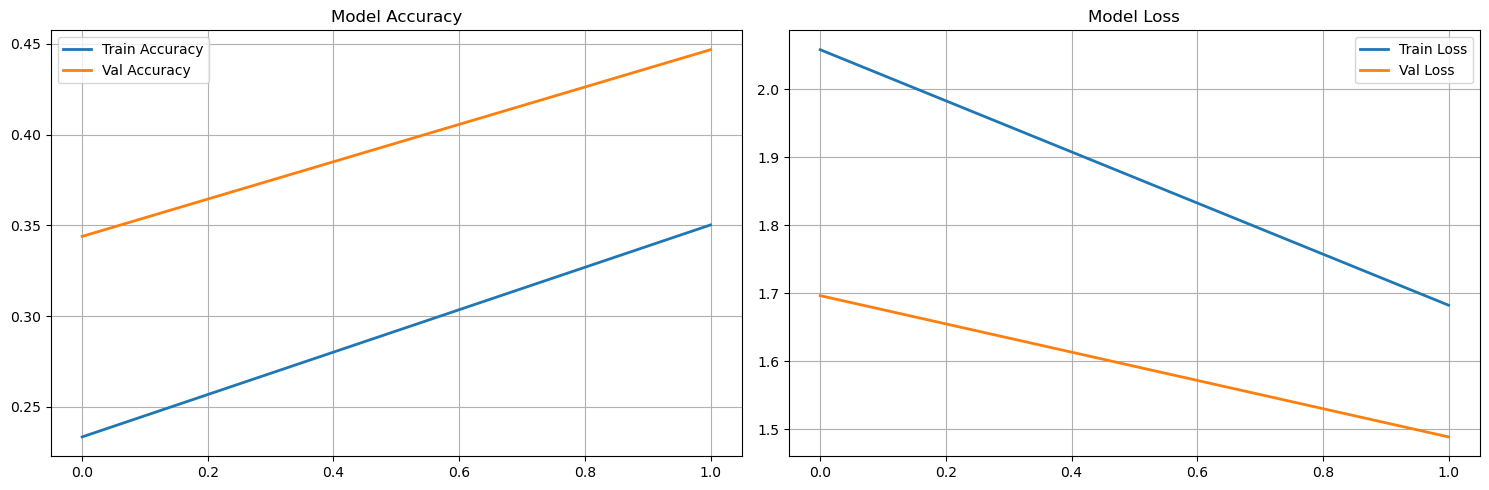

In [18]:

# After training
# history_head, history_ft = train_two_stage(...)

print ("plot both stages combined (recommended so plots show full training curve):")


# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_acc, label='Train Accuracy', linewidth=2)
axes[0].plot(val_acc, label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy'); axes[0].legend(); axes[0].grid(True)

axes[1].plot(train_loss, label='Train Loss', linewidth=2)
axes[1].plot(val_loss, label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss'); axes[1].legend(); axes[1].grid(True)

plt.tight_layout()
plt.show()
#print(f"📊 Final Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")


📊 FINAL EVALUATION
Training Accuracy:   0.4202 (42.02%)
Validation Accuracy: 0.4468 (44.68%)
Training Loss:       1.5326
Validation Loss:     1.4890


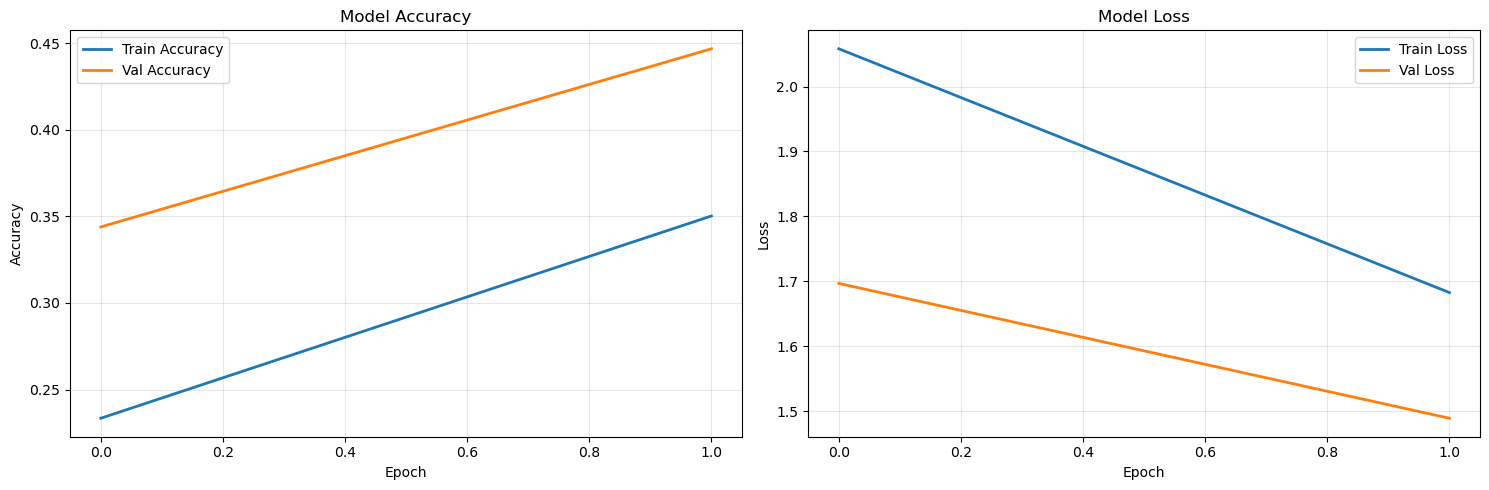

In [19]:
# =======================================================================
# Training History Visualization
# =======================================================================

# 1) Get scalar evaluation results from the model (safe)
train_loss, train_acc = model.evaluate(train_set, verbose=0)
val_loss, val_acc = model.evaluate(validation_set, verbose=0)

print("\n" + "="*70)
print("📊 FINAL EVALUATION")
print("="*70)
print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Validation Loss:     {val_loss:.4f}")
print("="*70)

# 2) Consolidate histories (head + fine-tune) for plotting if present
def _get_hist_list(h):
    return h.history if h is not None else {}

head_hist = history_head if 'history_head' in globals() else None
ft_hist = history_ft if 'history_ft' in globals() else None

# Combine metrics safely
def _concat_metric(metric):
    vals = []
    if head_hist is not None:
        vals += head_hist.history.get(metric, [])
    if ft_hist is not None:
        vals += ft_hist.history.get(metric, [])
    return vals

train_acc_list = _concat_metric('accuracy')
val_acc_list = _concat_metric('val_accuracy')
train_loss_list = _concat_metric('loss')
val_loss_list = _concat_metric('val_loss')

def plot_training_history(history_data):
    """Plot training history with better formatting."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    axes[0].plot(history_data['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0].plot(history_data['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1].plot(history_data['loss'], label='Train Loss', linewidth=2)
    axes[1].plot(history_data['val_loss'], label='Val Loss', linewidth=2)
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


# Prepare history data dictionary for plotting
history_data = {
    'accuracy': train_acc_list,
    'val_accuracy': val_acc_list,
    'loss': train_loss_list,
    'val_loss': val_loss_list
}

# Plot the training history
plot_training_history(history_data)

In [20]:


# Final evaluation
print("\n" + "="*70)
print("📊 FINAL EVALUATION")
print("="*70)
train_loss, train_acc = model.evaluate(train_set, verbose=0)
val_loss, val_acc = model.evaluate(validation_set, verbose=0)

print(f"Training Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Validation Loss:     {val_loss:.4f}")
print("="*70)


📊 FINAL EVALUATION
Training Accuracy:   0.4158 (41.58%)
Validation Accuracy: 0.4468 (44.68%)
Training Loss:       1.5354
Validation Loss:     1.4890


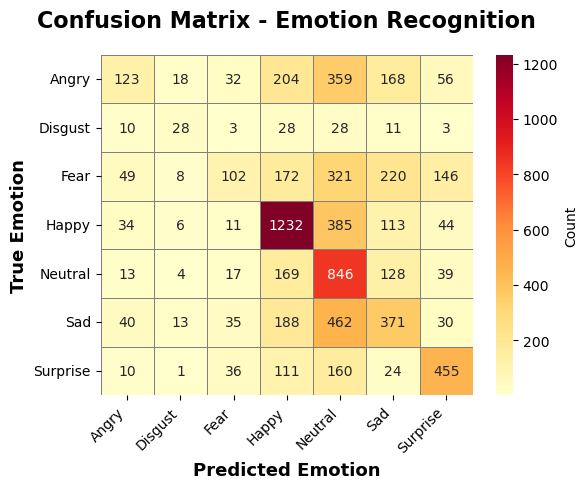

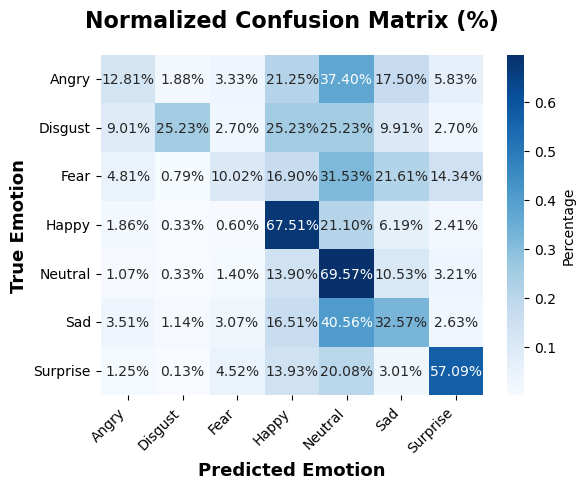


📈 DETAILED CLASSIFICATION METRICS
              precision    recall  f1-score   support

       Angry     0.4409    0.1281    0.1985       960
     Disgust     0.3590    0.2523    0.2963       111
        Fear     0.4322    0.1002    0.1627      1018
       Happy     0.5856    0.6751    0.6271      1825
     Neutral     0.3303    0.6957    0.4480      1216
         Sad     0.3585    0.3257    0.3413      1139
    Surprise     0.5886    0.5709    0.5796       797

    accuracy                         0.4468      7066
   macro avg     0.4421    0.3926    0.3791      7066
weighted avg     0.4601    0.4468    0.4145      7066



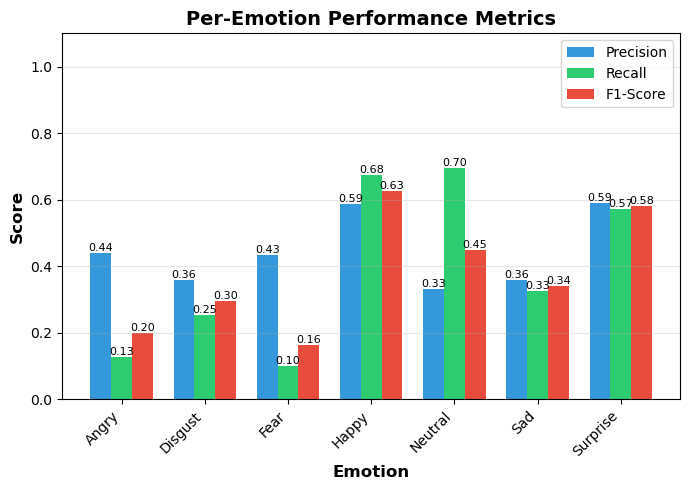


📊 PERFORMANCE SUMMARY TABLE
 Emotion Precision Recall F1-Score  Support
   Angry    44.09% 12.81%   19.85%      960
 Disgust    35.90% 25.23%   29.63%      111
    Fear    43.22% 10.02%   16.27%     1018
   Happy    58.56% 67.51%   62.71%     1825
 Neutral    33.03% 69.57%   44.80%     1216
     Sad    35.85% 32.57%   34.13%     1139
Surprise    58.86% 57.09%   57.96%      797

⚠️  TOP 5 MISCLASSIFICATION PAIRS
       Sad → Neutral    :  462 times
     Happy → Neutral    :  385 times
     Angry → Neutral    :  359 times
      Fear → Neutral    :  321 times
      Fear → Sad        :  220 times


In [23]:
# =======================================================================
# Enhanced Performance Visualizations
# =======================================================================
# Add this before the visualization section
validation_set.reset()
predictions = model.predict(validation_set, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_set.classes
cm = confusion_matrix(true_classes, predicted_classes)

# 1. Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'},
            linewidths=0.5,
            linecolor='gray')
plt.title('Confusion Matrix - Emotion Recognition', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Emotion', fontsize=13, fontweight='bold')
plt.ylabel('True Emotion', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (%)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Emotion', fontsize=13, fontweight='bold')
plt.ylabel('True Emotion', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Classification Report
print("\n" + "="*70)
print("📈 DETAILED CLASSIFICATION METRICS")
print("="*70)
print(classification_report(true_classes, predicted_classes, 
                           target_names=class_labels,
                           digits=4))

# 4. Per-Class Metrics Bar Chart
precision, recall, f1, support = precision_recall_fscore_support(
    true_classes, predicted_classes, labels=range(7)
)

fig, ax = plt.subplots(figsize=(7, 5))
x = np.arange(len(class_labels))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db')
bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71')
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Emotion', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Emotion Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Summary Table
summary_df = pd.DataFrame({
    'Emotion': class_labels,
    'Precision': [f'{p:.2%}' for p in precision],
    'Recall': [f'{r:.2%}' for r in recall],
    'F1-Score': [f'{f:.2%}' for f in f1],
    'Support': support.astype(int)
})

print("\n" + "="*70)
print("📊 PERFORMANCE SUMMARY TABLE")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

# 6. Misclassification Analysis
misclassified = cm.copy()
np.fill_diagonal(misclassified, 0)

top_confusions = []
for i in range(7):
    for j in range(7):
        if i != j:
            top_confusions.append((class_labels[i], class_labels[j], misclassified[i, j]))

top_confusions.sort(key=lambda x: x[2], reverse=True)

print("\n" + "="*70)
print("⚠️  TOP 5 MISCLASSIFICATION PAIRS")
print("="*70)
for true_label, pred_label, count in top_confusions[:5]:
    print(f"{true_label:>10} → {pred_label:<10} : {count:>4} times")
print("="*70)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.47450984].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.5921569].
Clipping input da

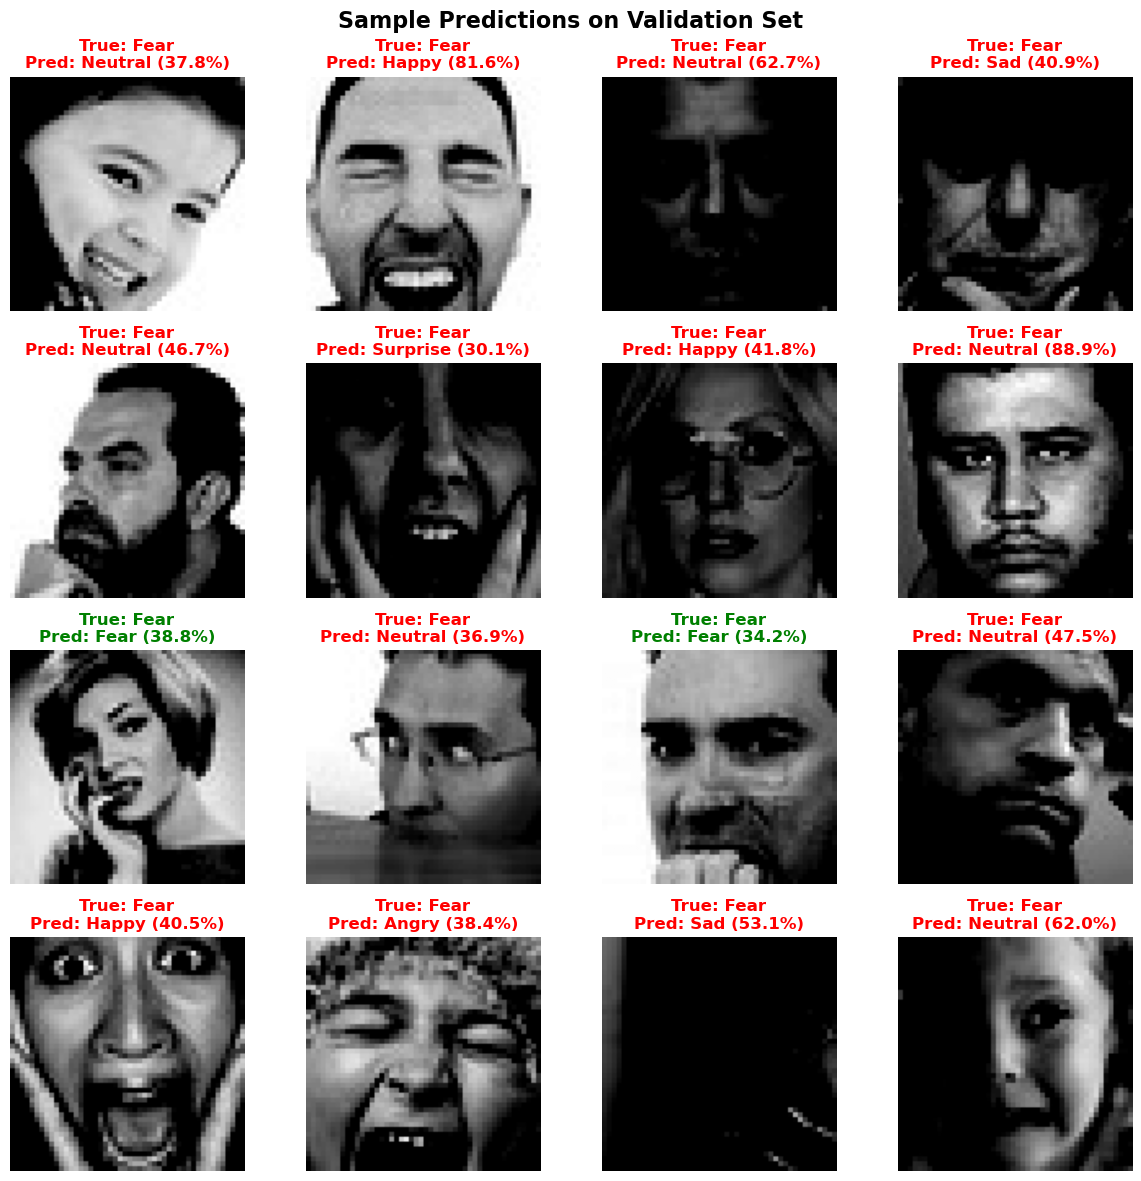

In [25]:
# =======================================================================
# Sample Predictions Visualization
# =======================================================================
import random

# Get a random batch from validation set
random_batch_idx = random.randint(0, len(validation_set) - 1)
sample_images, sample_labels = validation_set[random_batch_idx]

# Predict
sample_preds = model.predict(sample_images, verbose=0)
sample_pred_classes = np.argmax(sample_preds, axis=1)
sample_true_classes = np.argmax(sample_labels, axis=1)

# Randomly select 16 indices from the batch
num_samples = min(16, len(sample_images))
random_indices = random.sample(range(len(sample_images)), num_samples)

# Visualize predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    axes[i].imshow(sample_images[idx].squeeze(), cmap='gray')
    
    true_label = class_labels[sample_true_classes[idx]]
    pred_label = class_labels[sample_pred_classes[idx]]
    confidence = sample_preds[idx][sample_pred_classes[idx]] * 100

    # Color: green if correct, red if wrong
    color = 'green' if sample_true_classes[idx] == sample_pred_classes[idx] else 'red'
    
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)', 
                     color=color, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Predictions on Validation Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
print("Global policy:", mixed_precision.global_policy())
print("Model dtype policy:", model.dtype_policy)   # or model.input_dtype / model.output_dtype

Global policy: <DTypePolicy "float32">
Model dtype policy: <DTypePolicy "float32">
